In [3]:
# Import Statements
#--------------------------------------------------------------------------------------------------------------
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit import Aer
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#--------------------------------------------------------------------------------------------------------------

In [4]:
#--------------------------------------------------------------------------------------------------------------
# Define molecule LiH
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()
#--------------------------------------------------------------------------------------------------------------

In [5]:
#--------------------------------------------------------------------------------------------------------------
freezeCoreTransformer = FreezeCoreTransformer()
qmolecule = freezeCoreTransformer.transform(qmolecule)
# Freeze orbitals 3,4 to reduce solution
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True,remove_orbitals=[3,4])]) 
#--------------------------------------------------------------------------------------------------------------
# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()
#--------------------------------------------------------------------------------------------------------------
# Hamiltonian
main_op = second_q_ops[0]
#--------------------------------------------------------------------------------------------------------------
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper' # Set mapper (can be modified)

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()
    
# Apply z2 reduction using auto method
converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True,z2symmetry_reduction='auto') 
#--------------------------------------------------------------------------------------------------------------
# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_beta,
             problem.molecule_data_transformed.num_alpha)
qubit_op = converter.convert(main_op, num_particles=num_particles)
#--------------------------------------------------------------------------------------------------------------
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2* problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter,)
print(init_state)
#--------------------------------------------------------------------------------------------------------------

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


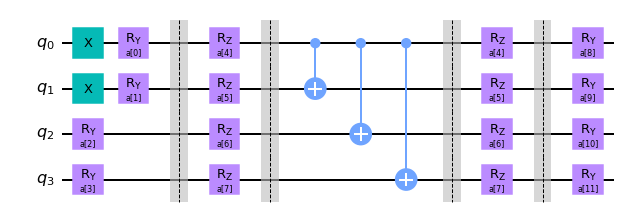

In [9]:
#--------------------------------------------------------------------------------------------------------------
ansatz_type = "Custom" # Change here
#--------------------------------------------------------------------------------------------------------------
# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
#--------------------------------------------------------------------------------------------------------------
# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'circular'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
#--------------------------------------------------------------------------------------------------------------    
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
#--------------------------------------------------------------------------------------------------------------
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
#--------------------------------------------------------------------------------------------------------------
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
#--------------------------------------------------------------------------------------------------------------
elif ansatz_type == "Custom": #Ansatz used = 3 CNOT Ladder.
    theta = ParameterVector('a', length=16)
    n = qubit_op.num_qubits
    
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    
    # Place a RY block
    for i in range(n):
        qc.ry(theta[i], i)
    qc.barrier()
    
    # Place RZ block
    for i in range(n):
        qc.rz(theta[(4+i)], i)
    qc.barrier()
    
    # Place CNOT ladder
    for i in range(1,n):
        qc.cx(0,i)
    qc.barrier()
    
    # Place RZ block
    for i in range(n):
        qc.rz(theta[(4+i)], i)
    qc.barrier()   
    
    # Place a RY block
    for i in range(n):
        qc.ry(theta[(8+i)], i)
        
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
#--------------------------------------------------------------------------------------------------------------
ansatz.draw(output="mpl")
#--------------------------------------------------------------------------------------------------------------

In [10]:
#--------------------------------------------------------------------------------------------------------------
backend = Aer.get_backend('statevector_simulator')
optimizer_type = 'L_BFGS_B' # Set optimizer type. Can be modified and tuned
#--------------------------------------------------------------------------------------------------------------
# You may want to tune the parameters 
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=10000)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=5000)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=10000)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=10000)
#--------------------------------------------------------------------------------------------------------------

In [11]:
#Ideal result
#--------------------------------------------------------------------------------------------------------------
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result
#--------------------------------------------------------------------------------------------------------------
result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)
#--------------------------------------------------------------------------------------------------------------

Exact electronic energy -1.0887060157347406
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


In [12]:
# Optimizer result
#--------------------------------------------------------------------------------------------------------------
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
#--------------------------------------------------------------------------------------------------------------
counts = []
values = []
params = []
deviation = []
#--------------------------------------------------------------------------------------------------------------
# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
#--------------------------------------------------------------------------------------------------------------
algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)
#--------------------------------------------------------------------------------------------------------------
result = algorithm.compute_minimum_eigenvalue(qubit_op)
#--------------------------------------------------------------------------------------------------------------
print(result)
#--------------------------------------------------------------------------------------------------------------

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 533,
    'eigenstate': array([ 4.81545519e-04-9.08938287e-07j, -3.37920042e-04-4.38287521e-07j,
        2.52782438e-02-4.82836312e-05j,  9.89085673e-01-1.88845732e-03j,
        5.90396205e-02-1.08096628e-04j, -1.53434046e-03+2.72767295e-06j,
       -2.98823986e-02+5.84361301e-05j,  3.19207948e-02+8.58542945e-05j,
       -9.21301578e-04+1.68682016e-06j,  2.36880179e-05-4.23416212e-08j,
        4.86313526e-04-9.95957846e-07j,  2.76942721e-04-4.59677943e-06j,
       -1.11019986e-01+2.03264391e-04j,  2.86595710e-03-5.24720835e-06j,
        5.77028700e-02-1.05649307e-04j, -1.48047701e-03+2.62478693e-06j]),
    'eigenvalue': -1.088622359775475,
    'optimal_parameters': {   ParameterVectorElement(a[7]): 8.762365934159092e-06,
                              ParameterVectorElement(a[8]): 3.089974493122016,
                              ParameterVectorElement(a[9]): -0.4789936031101068,
                              ParameterVector

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,L_BFGS_B,QuantumCircuit,4,12,None,None,None,None,0.083656,True,3


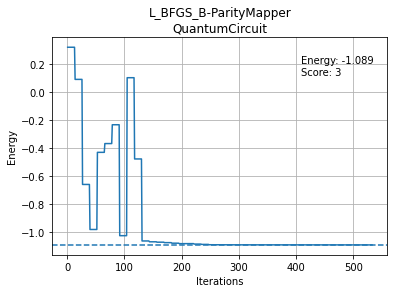

In [13]:
#--------------------------------------------------------------------------------------------------------------
# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
#--------------------------------------------------------------------------------------------------------------
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value
#--------------------------------------------------------------------------------------------------------------
if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
#--------------------------------------------------------------------------------------------------------------
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
#--------------------------------------------------------------------------------------------------------------
# Plot the results
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)
#--------------------------------------------------------------------------------------------------------------
# Display and save the data
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
#--------------------------------------------------------------------------------------------------------------
else:
    result_df = pd.DataFrame.from_dict([result_dict])
#--------------------------------------------------------------------------------------------------------------
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]
#--------------------------------------------------------------------------------------------------------------

In [14]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.

